In [1]:
import pandas as pd
import numpy as np

from datasets import Dataset

In [29]:
fx = pd.read_csv(
    'data/EURUSD_1min.txt',
    names = ['day', 'time', 'open',
            'high', 'low', 'close', 'volume'])

fx['datetime'] = fx['day'].astype(str) + " " + fx['time']
fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

fx = fx.drop(columns = ['day', 'time'])

# Preprocessing

- Step 1: linearly interpolate gaps (shoot, not sure how to do this in parallel besides filling in all gaps and then getting rid of friday -> sunday
- Step 2: so we will go from 21:00 to 21:00 from sunday to friday
    - make a "trading day" feature starting from 21:00 of 
    - get rid of stragler days with no trades at end and beginning if the don't match up right
- Step 3: subtract the day's open at 21:00 from each day (group by day easy) -- let's not honestly...
- Step 4: make relative volume indicator using comparing real volume to groupby day's MA -- yeah I mean for now let's not
- Step 5: 60min HLC

- Step 6: create train, validation and test datasets
- Step 7: divide each column by their std (ungrouped) USING ONLY TRAINING SET MAKING SURE TO SAVE THIS NUMBER -- not for now


Make JSON:
- make the weekday and relative volume a feature
- make inputs_embeds a 2d array containing OHLCV and label 2D array of HLC (no day of week)
- store as JSON

In [3]:
# Linearly interpolate time gaps
fx = fx.set_index('datetime').asfreq('1min')
fx['close'] = fx['close'].fillna(method = 'ffill')
fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

# fill open high and low with most recent close
fx = fx.fillna({
    'open': fx['close'],
    'high': fx['close'],
    'low': fx['close']
})

In [4]:
# define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
fx['day'] = fx.index.dayofweek 
fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

# ordinal trading day since start of data (just for help in preprocessing)
fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

<AxesSubplot:>

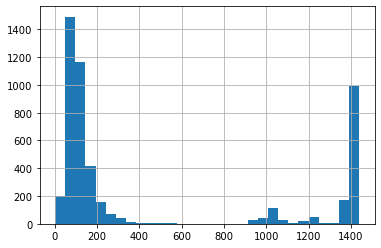

In [5]:
# look at distribution of how many mintues with price change (low volume)
(fx['close'] == fx['close'].shift(1)).groupby(fx['ordinal_day']).sum().hist(bins = 30)

In [16]:
# let's just arbitrary say there should be less than 400 no change minutes (get rid of low to no volume days)
voluminous_index = (fx['close'] == fx['close'].shift(1)).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 400).index
fx = fx.loc[voluminous_index]

In [17]:
# quick sanity check of data 
fx.between_time('20:59', '21:01')

,open,high,low,close,day,ordinal_day
datetime,,,,,,
2020-04-07 20:59:00,1.08920,1.08920,1.08920,1.08920,1,1
2020-04-07 21:00:00,1.08910,1.08920,1.08910,1.08920,2,2
2020-04-07 21:01:00,1.08920,1.08920,1.08920,1.08920,2,2
2020-04-08 20:59:00,1.08550,1.08550,1.08540,1.08540,2,2
2020-04-08 21:00:00,1.08580,1.08595,1.08580,1.08595,3,3
...,...,...,...,...,...,...
2022-11-01 21:00:00,0.98750,0.98750,0.98750,0.98750,2,940
2022-11-01 21:01:00,0.98745,0.98745,0.98745,0.98745,2,940
2022-11-02 20:59:00,0.98160,0.98180,0.98160,0.98180,2,940


# Twelvedata

In [12]:
fx = pd.read_csv('data/twelvedata/EUR_USD.csv')
fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

In [13]:
# Linearly interpolate time gaps
fx = fx.set_index('datetime').asfreq('1min')
fx['close'] = fx['close'].fillna(method = 'ffill')

# fill open high and low with most recent close
fx = fx.fillna({
    'open': fx['close'],
    'high': fx['close'],
    'low': fx['close']
})

In [14]:
# define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
fx['day'] = fx.index.dayofweek 
fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

# ordinal trading day since start of data (just for help in preprocessing)
fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

<AxesSubplot:>

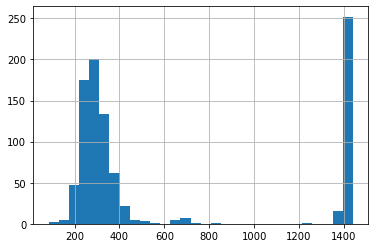

In [15]:
# look at distribution of how many 0 volume minute
(fx['close'] == fx['close'].shift(1)).groupby(fx['ordinal_day']).sum().hist(bins = 30)

# All data

In [1]:
import os
import pandas as pd
import numpy as np

import datasets
from datasets import Dataset, concatenate_datasets

# Start with processing all CSVs to datasets

In [5]:
def make_dataset(filename, periods = 60):
    if filename.startswith('./data/1mins'):
        fx = pd.read_csv(
        filename,
        names = ['day', 'time', 'open',
                'high', 'low', 'close', 'volume'])

        fx['datetime'] = fx['day'].astype(str) + " " + fx['time']
        fx = fx.drop(columns = ['day', 'time'])
        fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)
        
        # since twelve data will cover from then onwards
        fx = fx.loc[:'2020-04-07']
    elif filename.startswith('./data/twelvedata'):
        fx = pd.read_csv(filename)
        fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)
    
    # Linearly interpolate time gaps
    fx = fx.set_index('datetime').asfreq('1min')
    fx['close'] = fx['close'].fillna(method = 'ffill')

    # fill open high and low with most recent close
    fx = fx.fillna({
        'open': fx['close'],
        'high': fx['close'],
        'low': fx['close']
    })
    
    # define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
    fx['day'] = fx.index.dayofweek 
    fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
    fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

    # ordinal trading day since start of data (just for help in preprocessing)
    fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()
    
    # let's just arbitrary say there should be less than 400 no change minutes (get rid of low to no volume days)
    voluminous_index = (fx['close'] == fx['close'].shift(1)).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 400).index
    fx = fx.loc[voluminous_index]

    futures = {}
    for i in range(1, periods + 1):
        col_name = f'future_close{i}'
        futures[col_name]  = fx['close'].shift(-i) - fx['close']
    futures_df = pd.DataFrame(futures)
    future_cols = futures_df.columns

    fx = pd.concat((fx, futures_df), axis = 1)
    
    # clean up data odditity of future columns coming from the future of non-consecutive days (i.e. no overnight trading)
    fx['day_break'] = ((fx['day'] != (fx['day']).shift(-1)) & (fx['day'] != (fx['day'] - 1).shift(-1)))
    no_futures = fx[fx.groupby('ordinal_day')['day_break'].transform('any')].between_time(f'{20 - periods // 60}:{59 - periods % 60}', '20:59').index
    fx.loc[no_futures, future_cols] = 0
    
    # de mean using opening price of day
    fx['day_close'] = fx['close'].sub(fx.groupby('ordinal_day')['close'].transform('first'), axis = 0)
    fx[['open', 'high', 'low']] = fx[['open', 'high', 'low']].sub(fx['close'], axis = 0)
    fx['close'] = fx['close'] - fx['close'].shift(1)
    
    # get rid of first and last day due to data incompleteness
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].min()].index)
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].max()].index)
    
    features = ['open', 'high', 'low', 'close', 'day_close']
    
    stds = fx.iloc[:int(len(fx) * .9)][features].std(axis = 0)
    fx[features] = fx[features].div(stds, axis = 1)
    
    print(filename, '\n', repr(stds.values))
    
    ohlcv = fx[features].values.reshape(-1, 1440, 5)
    future = fx[future_cols].values.reshape(-1, 1440, periods)
    
    # save some memory
    del fx
    
    ds = Dataset.from_dict({"ohlcv": ohlcv, "future": future})
    
    return ds

In [3]:
data_dir = "./data/1mins/"
for file in os.listdir(data_dir):
    dataset = make_dataset(data_dir + file)
    dataset.save_to_disk(f"data/sets/{file[:7]}.ds")

./data/1mins/AUDUSD_1min.txt 
 array([0.00021721, 0.00015546, 0.00015462, 0.00022247, 0.00526431])
./data/1mins/EURCHF_1min.txt 
 array([0.00020018, 0.00015932, 0.00016135, 0.0002044 , 0.00458594])
./data/1mins/EURGBP_1min.txt 
 array([0.0001416 , 0.00010584, 0.00010687, 0.00014365, 0.00315551])
./data/1mins/EURJPY_1min.txt 
 array([0.02979671, 0.02138034, 0.02135969, 0.03035297, 0.70318711])
./data/1mins/EURUSD_1min.txt 
 array([0.00024709, 0.0001771 , 0.00017815, 0.00025166, 0.00558102])
./data/1mins/GBPJPY_1min.txt 
 array([0.03579834, 0.026064  , 0.02611605, 0.03635724, 0.83814371])
./data/1mins/GBPUSD_1min.txt 
 array([0.00027971, 0.00020617, 0.00020588, 0.00028495, 0.0062404 ])
./data/1mins/USDCAD_1min.txt 
 array([0.00019273, 0.00014654, 0.00014633, 0.00020033, 0.00404176])
./data/1mins/USDCHF_1min.txt 
 array([0.00020071, 0.00014892, 0.00014858, 0.00020432, 0.00454653])
./data/1mins/USDJPY_1min.txt 
 array([0.01716284, 0.01285   , 0.01272735, 0.01755535, 0.41071785])


# now TwelveData

In [6]:
data_dir = "./data/twelvedata/"
for file in os.listdir(data_dir):
    dataset = make_dataset(data_dir + file)
    dataset.save_to_disk(f"data/sets/twelve_{file[:7]}.ds")

./data/twelvedata/AUD_CAD.csv 
 array([0.00018097, 0.00012721, 0.00013315, 0.00018941, 0.00268662])
./data/twelvedata/AUD_CHF.csv 
 array([1.37778030e-04, 9.79979016e-05, 9.91099518e-05, 1.48218023e-04,
       2.68455916e-03])
./data/twelvedata/AUD_JPY.csv 
 array([0.01665746, 0.01135966, 0.01129499, 0.01812697, 0.40310416])
./data/twelvedata/AUD_NZD.csv 
 array([0.00017239, 0.00012595, 0.00012756, 0.00018005, 0.00245304])
./data/twelvedata/AUD_USD.csv 
 array([1.33835106e-04, 8.99916107e-05, 8.92213424e-05, 1.48887039e-04,
       3.12024080e-03])
./data/twelvedata/CAD_CHF.csv 
 array([0.0001521 , 0.00011196, 0.00010982, 0.00015848, 0.00230064])
./data/twelvedata/CAD_JPY.csv 
 array([0.017607  , 0.01241396, 0.01194279, 0.01861588, 0.36439691])
./data/twelvedata/CHF_JPY.csv 
 array([0.02005409, 0.01504193, 0.015535  , 0.02112835, 0.38129505])
./data/twelvedata/EUR_AUD.csv 
 array([0.00025753, 0.00018015, 0.00018086, 0.00027922, 0.00560566])
./data/twelvedata/EUR_CAD.csv 
 array([0.00026

# Concat all datasets (done in 2 stages due to memory contraints)

In [7]:
data_dir = './data/sets/'
os.listdir(data_dir)

['AUDUSD_.ds',
 'EURCHF_.ds',
 'EURGBP_.ds',
 'EURJPY_.ds',
 'EURUSD_.ds',
 'GBPJPY_.ds',
 'GBPUSD_.ds',
 'twelve_AUD_CAD.ds',
 'twelve_AUD_CHF.ds',
 'twelve_AUD_JPY.ds',
 'twelve_AUD_NZD.ds',
 'twelve_AUD_USD.ds',
 'twelve_CAD_CHF.ds',
 'twelve_CAD_JPY.ds',
 'twelve_CHF_JPY.ds',
 'twelve_EUR_AUD.ds',
 'twelve_EUR_CAD.ds',
 'twelve_EUR_CHF.ds',
 'twelve_EUR_GBP.ds',
 'twelve_EUR_JPY.ds',
 'twelve_EUR_NZD.ds',
 'twelve_EUR_USD.ds',
 'twelve_GBP_AUD.ds',
 'twelve_GBP_CAD.ds',
 'twelve_GBP_CHF.ds',
 'twelve_GBP_JPY.ds',
 'twelve_GBP_NZD.ds',
 'twelve_GBP_USD.ds',
 'twelve_NZD_CAD.ds',
 'twelve_NZD_CHF.ds',
 'twelve_NZD_JPY.ds',
 'twelve_NZD_USD.ds',
 'twelve_USD_CAD.ds',
 'twelve_USD_CHF.ds',
 'twelve_USD_JPY.ds',
 'USDCAD_.ds',
 'USDCHF_.ds',
 'USDJPY_.ds']

In [8]:
# make eurusd the last dataset
filenames =[
    'AUDUSD_.ds',
    'EURCHF_.ds',
    'EURGBP_.ds',
    'EURJPY_.ds',
    'EURUSD_.ds',
    'GBPJPY_.ds',
    'GBPUSD_.ds',
    'twelve_AUD_CAD.ds',
    'twelve_AUD_CHF.ds',
    'twelve_AUD_JPY.ds',
    'twelve_AUD_NZD.ds',
    'twelve_AUD_USD.ds',
    'twelve_CAD_CHF.ds',
    'twelve_CAD_JPY.ds',
    'twelve_CHF_JPY.ds',
    'twelve_EUR_AUD.ds',
    'twelve_EUR_CAD.ds',
    'twelve_EUR_CHF.ds',
    'twelve_EUR_GBP.ds',
    'twelve_EUR_JPY.ds',
    'twelve_EUR_NZD.ds',
    'twelve_GBP_AUD.ds',
    'twelve_GBP_CAD.ds',
    'twelve_GBP_CHF.ds',
    'twelve_GBP_JPY.ds',
    'twelve_GBP_NZD.ds',
    'twelve_GBP_USD.ds',
    'twelve_NZD_CAD.ds',
    'twelve_NZD_CHF.ds',
    'twelve_NZD_JPY.ds',
    'twelve_NZD_USD.ds',
    'twelve_USD_CAD.ds',
    'twelve_USD_CHF.ds',
    'twelve_USD_JPY.ds',
    'USDCAD_.ds',
    'USDCHF_.ds',
    'USDJPY_.ds',
    'twelve_EUR_USD.ds'
]

In [9]:
list_ds = [datasets.load_from_disk(data_dir + filename) for filename in filenames]

In [11]:
all_datasets = concatenate_datasets(list_ds)
all_datasets.save_to_disk("data/fx_days.ds")

In [12]:
datasets.load_from_disk("data/fx_days.ds")

Dataset({
    features: ['ohlcv', 'future'],
    num_rows: 31795
})